<a href="https://colab.research.google.com/github/Rafi653/Machine-Learning/blob/feature%2Flab1/ML_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Linear Regression

In [155]:
import pandas as pd
import numpy as np
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

In [179]:
from google.colab import files
#file = files.upload()  #upload file into google colab session

housing_df= pd.read_csv('housing.csv', header=None)

concrete_df= pd.read_csv('concreteData.csv', header=None)

yatch_df= pd.read_csv('yachtData.csv', header=None)

In [180]:
housing_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [181]:
concrete_df.head()

,0,1,2,3,4,5,6,7,8
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [182]:
yatch_df.head()

,0,1,2,3,4,5,6
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [209]:
class LinearRegression:
    def __init__(self, 
                 X,
                 y, learningRate,
                 tolerance,
                 maxIteration,
                 gd= False,
                 stochastic=False,
                 reg = False,
                 batch_size =100,
                 alpha=1.0) -> None:
        self.X= X
        self.y= y
        self.tolerance= tolerance
        self.learningRate= learningRate
        self.maxIteration= maxIteration
        self.gd= gd
        self.stochastic = stochastic
        self.reg = reg
        self.batch_size = batch_size
        self.alpha = alpha
        
    def splitTrainTest(self):
        X_train, X_test, y_train, y_test= train_test_split(self.X, self.y,
                                                           test_size= 0.3,
                                                           random_state=1)
        return (X_train, X_test, y_train, y_test)
    
    def add_X0(self,X):
        return np.column_stack([np.ones([X.shape[0],1]), X])
    
    def normalize(self,X):
        mean= np.mean(X,0)
        std= np.std(X,0)
        X_norm= (X - mean)/ std
        X_norm= self.add_X0(X_norm)
        return X_norm, mean, std
    
    def normalizetestdata(self, X, meanTrain, stdTrain):
        return (X- meanTrain)/ stdTrain

    def l2_regularization(self, w):
        """Calculate regularization term."""
        return self.alpha * 0.5 * np.linalg.norm(w, 2)

    def grad_reg_term(self,w):
        gradient_penalty = np.asarray(self.alpha) * w
        # Insert 0 for bias term.
        return np.insert(gradient_penalty, 0, 0, axis=0)
    
    def checkMatrix(self, X):
        X_rank= np.linalg.matrix_rank(X)
        
        if X_rank== min(X.shape[0], X.shape[1]):
            self.fullRank= True
            print('data is full rank')
        else:
            self.fullRank= False
            print('data is not full rank')
            
    def checkInvertibility(self,X):
        if X.shape[0] < X.shape[1]:
            self.lowRank= True
        else:
            self.lowrank= False
            
    def closedFormSolution(self, X,y):
        w= np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        return w

    def sgd_sample(self, X, y):
       
        n_obs = X.shape[0]

        xy = np.c_[X.reshape(n_obs, -1), y.reshape(n_obs, 1)]

        # Initializing the random number generator
        #seed = None if random_state is None else int(random_state)
        rng = np.random.default_rng(seed=None)

        rng.shuffle(xy)
        if not 0 < self.batch_size <= n_obs:
            raise ValueError(f"'batch_size' must be greater than zero and less than or equal to the number of observations: {n_obs}")
        start = random.randint(0, n_obs - self.batch_size)

        stop = start + self.batch_size
        x_batch, y_batch = xy[start:stop, :-1], xy[start:stop, -1:]
        y_batch = y_batch.reshape(-1)
        
        return x_batch, y_batch
    
    def gradientDescent(self,X,y):
        
        self.errors= []
        
        lastError= float('inf')
        
        if self.stochastic:
            print("solving using stochastic gradient descent")
        else:
            print("solving using gradient descent")
        gradient_reg = 0
        regularization = 0
        for t in tqdm(range(self.maxIteration)):
            if self.stochastic:
                X_batch, y_batch = self.sgd_sample(X, y)
            else:
                X_batch, y_batch = X, y

            if self.reg:
                gradient_reg = self.grad_reg_term(self.w[1:])
                regularization = self.l2_regularization(self.w[1:])

            self.w = self.w - self.learningRate * (self.costDerivation(X_batch,y_batch) + gradient_reg)
            
            #cur= self.sse(X_batch,y_batch) + regularization
            cur= self.rmse(X_batch,y_batch) + regularization
            
            diff= lastError - cur
            lastError= cur
            self.errors.append(cur)
            
            if abs(diff) < self.tolerance:
                print("The model stopped and no further improvement")
                break
        self.plot_cost(self.errors)
            
    def predict(self, X):
        return X.dot(self.w)
    
    def sse(self, X, y):
        y_hat= self.predict(X)
        return((y_hat-y)**2).sum()

    def rmse(self, X, y):
        n = X.shape[0]
        return np.sqrt(self.sse(X, y)/n)
    
    def costFunction(self, X, y):
        return self.sse(X, y)/ 2
    
    def costDerivation(self, X, y):
        y_hat= self.predict(X)
        return(y_hat - y).dot(X)

    def plot_cost(self, cost_sequence):
    # Data for plotting
      s = np.array(cost_sequence)
      t = np.arange(s.size)

      fig, ax = plt.subplots()
      ax.plot(t, s)

      ax.set(xlabel='iterations', ylabel='cost',
              title='cost trend')
      ax.grid()

      plt.legend(bbox_to_anchor=(1.05,1), loc=2, shadow=True)
      plt.show()

    def fit(self):
        
        self.X_train, self.X_test, self.y_train, self.y_test= self.splitTrainTest()
        
        #normalize the data
        self.X_train, meanTrain, stdTrain= self.normalize(self.X_train)
        self.X_test= self.normalizetestdata(self.X_test, meanTrain, stdTrain)
        
        self.checkInvertibility(self.X_train)
        self.checkMatrix(self.X_train)
        
        if self.fullRank and not self.lowrank and not self.gd:
            print("Solving using Normal equation - closed form solution")
            self.w= self.closedFormSolution(self.X_train, self.y_train)
            
        else:
            self.w= np.ones(self.X_train.shape[1], dtype= np.float64)*0
            self.gradientDescent(self.X_train, self.y_train)
            
            print(self.w)

In [190]:
regression = LinearRegression(housing_df.values[:,0:-1],
                              housing_df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 10000,
                              gd= True, 
                              stochastic = False, 
                              batch_size = 200)

data is full rank
solving using gradient descent


100%|██████████| 10000/10000 [00:00<00:00, 36215.64it/s]
No handles with labels found to put in legend.


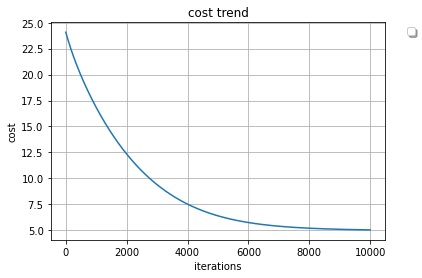

[21.69208379 -0.53296158  0.58086911 -0.26314026  0.82535902 -1.02627628
  2.62500212 -0.26331705 -1.71643781  0.65034604 -0.20749066 -1.88575757
  0.68446014 -3.4639267 ]


In [191]:
regression.fit()

In [192]:
regression = LinearRegression(concrete_df.values[:,0:-1],
                              concrete_df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 10000,
                              gd= True, 
                              stochastic = True, 
                              batch_size = 200)

data is full rank
solving using stochastic gradient descent


100%|██████████| 10000/10000 [00:13<00:00, 727.69it/s]
No handles with labels found to put in legend.


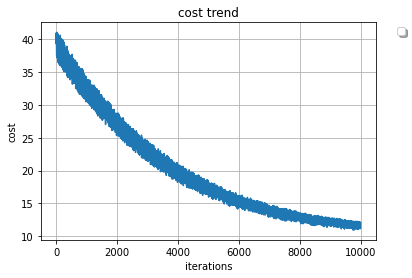

[30.88212052  6.63912813  2.64535829 -0.52322928 -4.58741515  4.09306688
 -1.71504661 -2.46114326  5.8562957 ]


In [193]:
regression.fit()

In [194]:
regression = LinearRegression(yatch_df.values[:,0:-1],
                              yatch_df.values[:, -1],
                              learningRate= 0.000001,
                              tolerance= 0.000005,
                              maxIteration= 10000,
                              gd= True, 
                              stochastic = True, 
                              reg=True,
                              batch_size = 200)

data is full rank
solving using stochastic gradient descent


 21%|██        | 2106/10000 [00:01<00:04, 1894.30it/s]
No handles with labels found to put in legend.


The model stopped and no further improvement


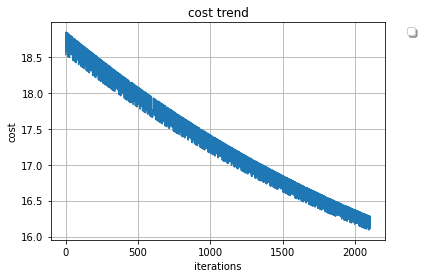

[ 3.6064658  -0.02333945 -0.16788319  0.04366242  0.00880537 -0.03144766
  4.32421427]


In [195]:
regression.fit()

Running Model on dataset: housing
data is full rank
solving using stochastic gradient descent


  0%|          | 228/50000 [00:00<00:41, 1197.54it/s]

The model stopped and no further improvement



No handles with labels found to put in legend.


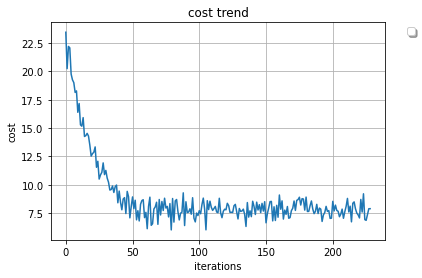

[22.30319475 -0.52042605  0.91461868 -0.19567151  0.70719021 -1.82605061
  2.20778608 -0.16124511 -2.49307348  1.18358704 -0.61440805 -1.94869715
  0.6493247  -3.82056051]
Running Model on dataset: concrete
data is full rank
solving using stochastic gradient descent


100%|██████████| 10000/10000 [00:14<00:00, 699.94it/s]
No handles with labels found to put in legend.


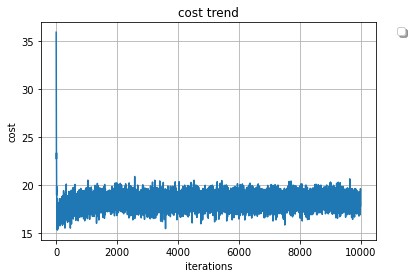

[ 3.57103960e+01  1.14248624e+01  7.38900749e+00  4.41740509e+00
 -3.89202847e+00  1.91184997e+00  2.85868339e-02  8.54108155e-02
  6.93730951e+00]
Running Model on dataset: yatch
data is full rank
solving using stochastic gradient descent


  3%|▎         | 1461/50000 [00:00<00:25, 1931.67it/s]
No handles with labels found to put in legend.


The model stopped and no further improvement


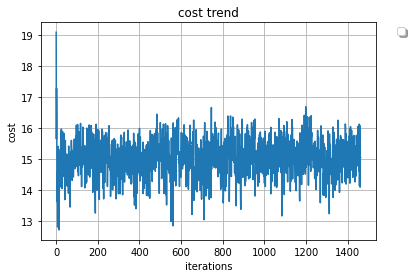

[10.42632079  0.28626628 -0.52289853  1.56978959 -0.99645992 -1.28006066
 12.3399797 ]


In [212]:

datasets = [{
    'name': 'housing',
    'kwargs': {
        'X': housing_df.values[:,0:-1],
        'y': housing_df.values[:, -1],
        'learningRate': 0.0004,
        'tolerance': 0.005,
        'maxIteration': 50000,
        'gd': True, 
        'stochastic': True, 
        'reg': True,
        'batch_size': 100,
        'alpha': 1.0
        }
    },
    {
    'name': 'concrete',
    'kwargs': {
        'X': concrete_df.values[:,0:-1],
        'y': concrete_df.values[:, -1],
        'learningRate': 0.0007,
        'tolerance': 0.0001,
        'maxIteration': 10000,
        'gd': True, 
        'stochastic': True, 
        'reg': True,
        'batch_size': 100,
        'alpha': 1.0
        }
    },
    {
    'name': 'yatch',
    'kwargs': {
        'X': yatch_df.values[:,0:-1],
        'y': yatch_df.values[:, -1],
        'learningRate': 0.001,
        'tolerance': 0.001,
        'maxIteration': 50000,
        'gd': True, 
        'stochastic': True, 
        'reg': True,
        'batch_size': 100,
        'alpha': 1.0
        }
    }
]

for d in datasets:
    print(f"Running Model on dataset: {d['name']}")
    model = LinearRegression(**d['kwargs'])
    model.fit()